In [5]:
import sys
sys.path.append('../src')
import numpy as np
import matplotlib.pylab as plt
from astropy import constants as const
from stellar import StellarSpectrum
from observations import Observations
from process import Process
from template import Template
from convolution import *
from interpolater import *
from vfinder import Velocity_Finder

# Tutorial: Using `pRVsim`

Welcome to the tutorial for **pRVsim**, a Python package designed to generate synthetic precision radial velocity (pRV) observations for a given star, instrument, and set of planetary parameters. The package is built around the **2D Spectroscopy (2DS)** framework, where each spectral order is generated and processed independently.

This tutorial outlines the main components and setup of the code.

---

## 1. Stellar Spectrum

The first step is to define the **stellar spectrum**. We will download and extract a PHOENIX Stellar Model according to the parameters you provide. The native sampling resolution of PHOENIX is **R = 500 000**.

### What You Need to Provide:
- **Stellar parameters** (e.g. effective temperature, metallicity, etc.)
- **Spectral resolution**: This defines how broadened your spectrum will be.
- **Oversampling**: This should be set such that the overall sampling resolution is **very high**, ideally around **12 pixels per FWHM** (full width at half maximum), even if the spectral resolution is moderate.
- **Instrument and order**: Specify the instrument and spectral order to determine the **wavelength range** over which the spectrum should be generated.
- **Signal-to-noise ratio (SNR)**:  
  This defines the **photon noise level** in your simulated spectrum.  
  > 💡 **Note**: This SNR refers to the counts per **1 km/s bin**, not per pixel.

  For example, if your detector has a pixel scale of **500 m/s** and you want about **10,000 counts per pixel**, the appropriate SNR value would be approximately **140** not 100.

---
## 2. Instrument Definition

Currently this simulation is only compatible with using orders from SPIRou or NIRPS. Therefore the wavelength ranges that can be evaluated can only be from the orders from SPIRou or NIRPS However, you can change the sampling resolution if you wish to have better or poorer sampling than the instrument you choose to use. The instrument variables you must define are the following:

### What You Need to Provide:
- **Instrument Spectral Resolution** This must be provided but should ideally match the SPIRou or NIRPS values
- **Use_Instrument_Grid**: This tells the code if you want to use the sampling resolution of the instrument you provided
- **Given Instrument Spectral Resolution**: If you don't want to use the sampling resolution of the instrument provided than this value will be used to define the sampling resolution of your observations

---
#### Key Variables 

In [6]:
''' Parameters to Determine Resolution of PHOENIX spectra '''
R_start = 200_000 # Broadening factor of PHOENIX spectra
oversample = 5 # Oversampling factor of PHOENIX spectra

''' Stellar Parameters'''
T = 2300
logg = 1
metal = 1

''' Instrument Information'''
inst = "spirou"
order = 20

''' SNR '''
SNR = 1e2

''' Parameters to Determine Instrument Resolution '''
inst_res = 70_000 # Broadening factor from instrument
use_instrument_wgrid = True # Are you going to use exactly spirou's grid or a constant resolution grid based off of a spirou order
def_inst_resolution = 150_000 # Sampling resolution if you don't use a specific instrument's resolution

In [7]:
# Define the spectrum
stellar = StellarSpectrum(order=order, T=T, logg=logg, metal=metal, starting_resolution=R_start, 
                 oversample=oversample, instrument=inst)

# We are going to immediately change this flux into a specific SNR flux
# This is valid because we do not bin into instrument wavelegth grid, we will interpolate to the instrument wavelength grid
final_stellar_spectrum = stellar.incorporate_SNR(SNR, use_inst_wgrid=use_instrument_wgrid, new_res=def_inst_resolution)

Text(0.5, 0, 'Wavelength (nm)')

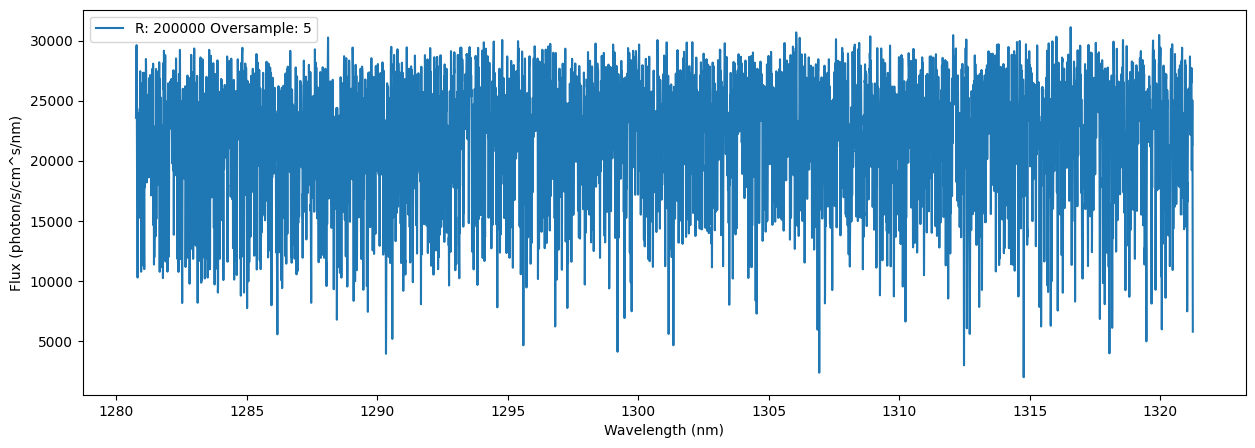

In [8]:
plt.figure(figsize=(15,5))
plt.plot(stellar.phoenix_wgrid,stellar.stellar,label="R: "+str(R_start)+" Oversample: "+str(oversample))
# plt.xlim(1290,1291)
plt.ylabel("Flux (photon/s/cm^s/nm)")
plt.legend()
plt.xlabel("Wavelength (nm)")

---

## 3. RV Curve

To define your **radial velocity (RV) curve**, the following inputs are currently required:

- **Date range**: The span of time over which your observations are made.
- **Number of observations**: How many RV points you want to simulate.
- **K amplitude**: The semi-amplitude of the planetary RV signal (in m/s).

Based on these, the code:
- Randomly samples observation dates within the specified range.
- Computes the **Barycentric Earth Radial Velocity (BERV)** for each date.
- Allows you to modify **observational parameters**, such as the **longitude** and **latitude** of the observatory on Earth.

### Planetary RV Curve
Currently, the planetary RV curve assumes:
- A **circular orbit**.
- A fixed **orbital frequency** of **0.08** (units assumed to be 1/day).

> 🚧 **Note**: In future versions, you will be able to:
> - Provide a predefined set of observation dates.
> - Simulate more complex planetary RV curves, including eccentric orbits and multiple planets.


In [13]:
# Define the observations object
N = 200
observations = Observations(native_wavegrid=stellar.phoenix_wgrid,instrument_wavegrid=stellar.inst_wgrid,num=N)

# Define the dates
start_date = '2020-01-01'
end_date = '2021-01-03'
date_seed = 43
dates = observations.dates(start_date,end_date,seed=date_seed)

# Define the curve
K_amp = 5
RV, planet = observations.RV_signal(planet_amp=K_amp)

Text(0.5, 0, 'Julian Dates')

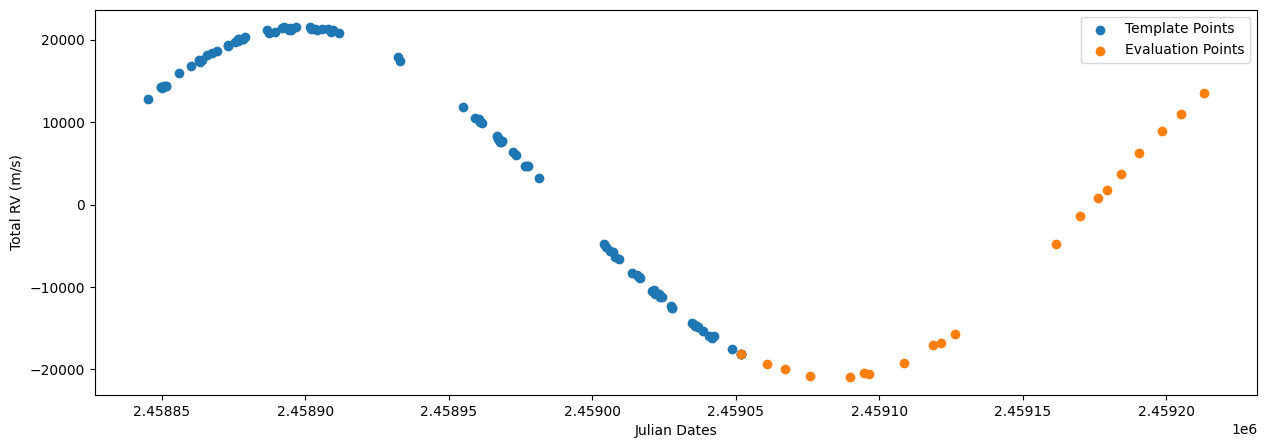

In [14]:
plt.figure(figsize=(15,5))
plt.scatter(observations.julian_dates[:100],observations.RV[:100],label="Template Points")
plt.scatter(observations.julian_dates[100:][::5],observations.RV[100:][::5],label="Evaluation Points")


plt.ylabel("Total RV (m/s)")
plt.legend()
plt.xlabel("Julian Dates")

Text(0.5, 0, 'Julian Dates')

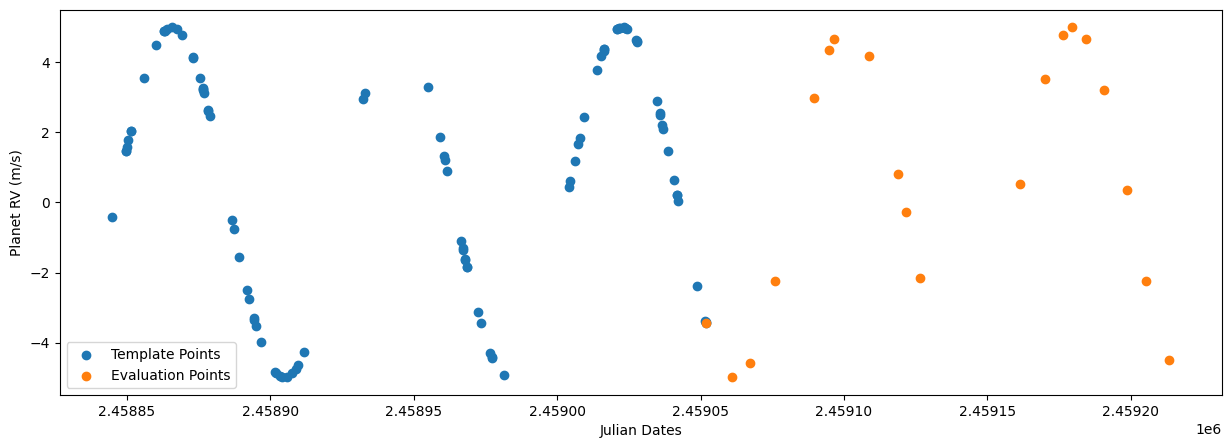

In [15]:
plt.figure(figsize=(15,5))
plt.scatter(observations.julian_dates[:100],observations.planet[:100],label="Template Points")
plt.scatter(observations.julian_dates[100:][::5],observations.planet[100:][::5],label="Evaluation Points")


plt.ylabel("Planet RV (m/s)")
plt.legend()
plt.xlabel("Julian Dates")

---

## 4. Creating Observations 

The following things will be completed:

- Doppler shifting
- Instrumental broadening
- Placing spectra in the sampling resolution of detector

In [16]:
# Doppler shift them
shifted = observations.doppler_shift(stellar.stellar)

# Put into Instrument Resolution 
inst_wgrid, inst_spec, convolved = observations.instrument_captures(inst_res,use_instrument_wgrid,new_res=def_inst_resolution)

# Create noisy observations
noisy, sig = observations.poisson(seed=10)

---

## 5. Post Process the Data
This is kept for posterity sake in case there needs to be additional post-processing done to the spectra once there is more complexity added to the simulation

In [18]:
processor = Process(observations.instrument_wgrid,observations.instrument_spectra)

---

## 6. Create the template
Here you simply have to provide which observations you want to use to create the template.

The following will be done to create the template: 
- Upsample the spectra
- BERV-register the spectra
- Take the median to create the template


In [19]:
# Number of epochs used to create the template
T_epochs = [2, 20, 100]
templates = []

for T in T_epochs:
    # We will only create the template out of T observations 
    
    # The template will be placed in an upsampled space, this will just be kept as the native (original)
    # grid of the observations to make it easy for comparison of the interpolation issue
    template_maker = Template(observations.berv[:100][::int(100/T)], upsampled_wgrid = observations.native_wgrid, inst_wgrid = observations.instrument_wgrid)

    # Shift the observations back by their berv
    shiftedflux, upsampledflux = template_maker.shift_back_by_bervs(processor.spectra[:100][::int(100/T)])

    # Take the median of these observations
    template = template_maker.create_template()

    templates.append(template)


---
# Plotting to show each step

In [20]:
# Which observations are you following
o = 0

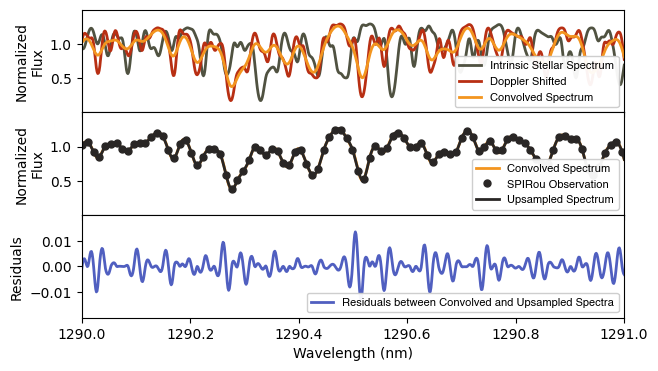

In [21]:
fig, axs = plt.subplots(3,1,figsize=(7,4),sharex=True)
colors = ['#505FC0', '#b82f13', '#f3951f', '#505241', '#88a66e', '#292625']
# colors =  ['#4E5BAF', '#C3411F', '#E18D2D', '#5A5E48', '#7DA46D', '#2C2A28']

plt.rcParams["font.family"] = "Helvetica"
# plt.tight_layout()
plt.subplots_adjust(hspace=0)
axs[0].plot(stellar.phoenix_wgrid,stellar.stellar/np.median(stellar.stellar),label="Intrinsic Stellar Spectrum",c=colors[3],lw=2)
axs[0].plot(stellar.phoenix_wgrid,shifted[o]/np.median(stellar.stellar),label="Doppler Shifted",c=colors[1],lw=2)
axs[0].plot(stellar.phoenix_wgrid,convolved[o]/np.median(stellar.stellar),label="Convolved Spectrum",c=colors[2],lw=2)
axs[0].legend(loc="lower right",fontsize=8,framealpha=0.95)
axs[1].plot(stellar.phoenix_wgrid,convolved[o]/np.median(stellar.stellar),label="Convolved Spectrum",c=colors[2],lw=2)
axs[1].plot(observations.instrument_wgrid,inst_spec[o]/np.median(stellar.stellar),label="SPIRou Observation",c=colors[-1],ls="",marker="o",markersize=5)
axs[1].plot(observations.native_wgrid,upsampledflux[o]/np.median(stellar.stellar),label="Upsampled Spectrum",c=colors[-1],lw=2)
axs[1].legend(loc="lower right",fontsize=8,framealpha=0.95)
axs[2].plot(stellar.phoenix_wgrid,(convolved[o]-upsampledflux[o])/np.median(stellar.stellar),label="Residuals between Convolved and Upsampled Spectra",c=colors[0],lw=2)
axs[2].set_xlim(1290,1291)
axs[2].legend(loc="lower right",fontsize=8,framealpha=0.95)
axs[0].set_ylabel("Normalized\nFlux",fontsize=10)
axs[1].set_ylabel("Normalized\nFlux",fontsize=10)
axs[2].set_ylabel("Residuals",fontsize=10)
axs[2].set_xlabel("Wavelength (nm)",fontsize=10)
axs[0].set_ylim(0,1.5)
axs[1].set_ylim(0,1.5)
axs[2].set_ylim(-0.02,0.02)
axs[0].set_yticks([0.5,1])
axs[1].set_yticks([0.5,1])
axs[2].set_yticks([-0.01,0,0.01])

# plt.savefig("interp_relative.pdf")

---
# Now let's find the RVs
Here we need to define which obsrevations we want to find the RV for and also the RV interval defined in Silva et al. 2022.

In [22]:
evaluation_points = np.arange(0,200,1)[100:][::5]
# General uncertainty for SPIROU rv is 1m/s
RV_interval = 1

## Let's first find it for the templates

In [23]:
template_retrieved_RVs = np.zeros((3,20))
template_uncs = np.zeros((3,20))

# Iterate through each template
for k,template in enumerate(templates):
    retrieved = np.zeros(20)
    uncs =  np.zeros(20)

    # Iterate through each evaluation point
    for j,o in enumerate(evaluation_points):
        # First we will just shift the template by berv
        total_shift = observations.berv[o]
        iterated_RVs = np.zeros(5)

        # Find the planet RV iteratively
        for i in range(5):
            # Define the finder object
            vf = Velocity_Finder(template,observations.native_wgrid,observations.instrument_wgrid,total_shift,False,T_epochs=T_epochs[k])

            # Determine the RV
            RV, uncRV = vf.find_dv(processor.spectra[o],RV_interval,sig[o])

            # Next time we will shift the template by the berv plus this additional RV
            total_shift+=RV[0]
            iterated_RVs[i] = RV[0]
            
            if RV<=0.001:
                break
                
        # Determine the uncertainty after you found the RV
        uncRV = vf.find_unc(processor.spectra[o],sig[o],np.sum(iterated_RVs),RV_interval)

        template_retrieved_RVs[k][j] = np.sum(iterated_RVs)
        template_uncs[k][j] = uncRV[0]

/var/folders/vw/5qpldskx1hn6wrghx5fk63v40000gn/T/ipykernel_9069/1863525040.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  template_uncs[k][j] = uncRV


## Now for the intrinsic spectrum

In [24]:
base_retrieved = np.zeros(20)
base_uncs = np.zeros(20)
# Iterate through each evaluation point
for j,o in enumerate(evaluation_points):
    # First we will just shift the template by berv
    total_shift = observations.berv[o]
    iterated_RVs = np.zeros(5)

    # Find the planet RV iteratively
    for i in range(5):
        # Define the finder object
        vf = Velocity_Finder(stellar.stellar,observations.native_wgrid,observations.instrument_wgrid,total_shift,True,inst_res)

        # Determine the RV
        RV, uncRV = vf.find_dv(processor.spectra[o],RV_interval,sig[o])

        # Next time we will shift the template by the berv plus this additional RV
        total_shift+=RV[0]
        iterated_RVs[i] = RV[0]
        
        if RV<=0.001:
            break
            
    # Determine the uncertainty after you found the RV
    uncRV = vf.find_unc(processor.spectra[o],sig[o],np.sum(iterated_RVs),RV_interval)

    base_retrieved[j] = np.sum(iterated_RVs)
    base_uncs[j] = uncRV[0]

/var/folders/vw/5qpldskx1hn6wrghx5fk63v40000gn/T/ipykernel_9069/220615723.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  base_uncs[j] = uncRV


---
# Let's see how well the RVs are

In [25]:
from scipy.optimize import curve_fit
def sine_function(x, A, D):
    return A * np.sin(0.08*x) + D
initial_guess = [50,0]

In [26]:
# Fit the retrieved RVs to a sin curve to remove the vertical offset in template retrieved RVs

params = np.zeros((4,2))
unc_params = np.zeros((4,2))

for i in range(4):
    if i==3:
        variables, params_covariance = curve_fit(sine_function, observations.julian_dates[100:][::5], base_retrieved, p0=initial_guess,sigma=base_uncs,absolute_sigma=True)
        params[i] = variables
        unc_params[i][0] = params_covariance[0][0]
        unc_params[i][1] = params_covariance[1][1]

    else:
        variables, params_covariance = curve_fit(sine_function, observations.julian_dates[100:][::5], template_retrieved_RVs[i], p0=initial_guess,sigma=template_uncs[i],absolute_sigma=True)
        params[i] = variables
        unc_params[i][0] = params_covariance[0][0]
        unc_params[i][1] = params_covariance[1][1]


In [27]:
# Calculate the  RMSE
real = observations.planet[100:][::5]

chis = []
for i in range(4):
    if i==3:
        chis.append(np.sqrt(np.mean((real-(base_retrieved-params[i][1]))**2)))
    else:
        chis.append(np.sqrt(np.mean((real-(template_retrieved_RVs[i]-params[i][1]))**2)))

Text(0.5, 0, 'Julian Dates')

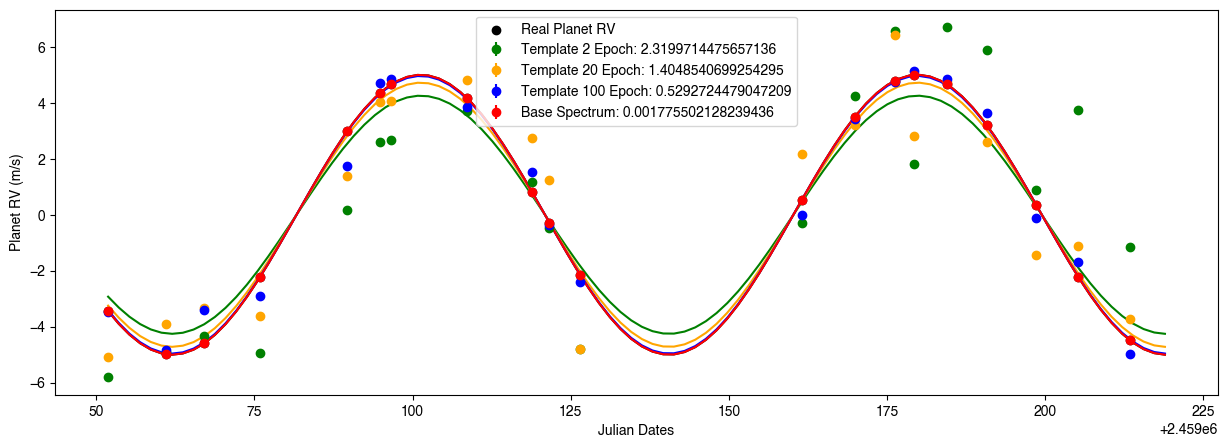

In [28]:
x = np.linspace(observations.julian_dates[100],observations.julian_dates[-1],100)

plt.figure(figsize=(15,5))
plt.scatter(observations.julian_dates[100:][::5],observations.planet[100:][::5],label="Real Planet RV",color="k")
plt.plot(x,sine_function(x,K_amp,0),color="k")

colors = ['green','orange','blue','red']

for i in range(4):

    if i==3:
        plt.errorbar(observations.julian_dates[100:][::5],base_retrieved-params[i][1],base_uncs[1],
                label="Base Spectrum: "+str(chis[i]),ls="",marker="o",color=colors[i])
        plt.plot(x,sine_function(x,params[i][0],0),color=colors[i])
        
    else:
        plt.errorbar(observations.julian_dates[100:][::5],template_retrieved_RVs[i]-params[i][1],template_uncs[1],
                label="Template "+str(T_epochs[i])+" Epoch: "+str(chis[i]),ls="",marker="o",color=colors[i])
        plt.plot(x,sine_function(x,params[i][0],0),color=colors[i])
        
plt.legend()
plt.ylabel("Planet RV (m/s)")
plt.xlabel("Julian Dates")